# Example Data Science Notebook

This notebook demonstrates basic data analysis workflows.

In [2]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path().resolve().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ds.analyzer import DataAnalyzer
from de.load.loader import DataLoader

print("Imports successful!")

Imports successful!


## Load Sample Data

In [3]:
# Create sample data
np.random.seed(42)
data = {
    'feature1': np.random.randn(100),
    'feature2': np.random.randn(100),
    'feature3': np.random.randn(100),
    'target': np.random.randint(0, 2, 100)
}
df = pd.DataFrame(data)
df.head()

,feature1,feature2,feature3,target
0,0.496714,-1.415371,0.357787,0
1,-0.138264,-0.420645,0.560785,1
2,0.647689,-0.342715,1.083051,1
3,1.523030,-0.802277,1.053802,0
4,-0.234153,-0.161286,-1.377669,0


## Exploratory Data Analysis

In [4]:
analyzer = DataAnalyzer(df)
analyzer.summary_stats()

INFO:ds.analyzer:Initialized DataAnalyzer with 100 rows
INFO:ds.analyzer:Generating summary statistics


,feature1,feature2,feature3,target
count,100.000000,100.000000,100.000000,100.000000
mean,-0.103847,0.022305,0.064896,0.420000
std,0.908168,0.953669,1.084283,0.496045
min,-2.619745,-1.918771,-3.241267,0.000000
25%,-0.600906,-0.805661,-0.655444,0.000000
50%,-0.126956,0.084107,0.097696,0.000000
75%,0.405952,0.538170,0.704437,1.000000
max,1.852278,2.720169,3.852731,1.000000


In [5]:
# Check for missing values
analyzer.check_missing()

INFO:ds.analyzer:Total missing values: 0


feature1    0
feature2    0
feature3    0
target      0
dtype: int64

## Visualizations

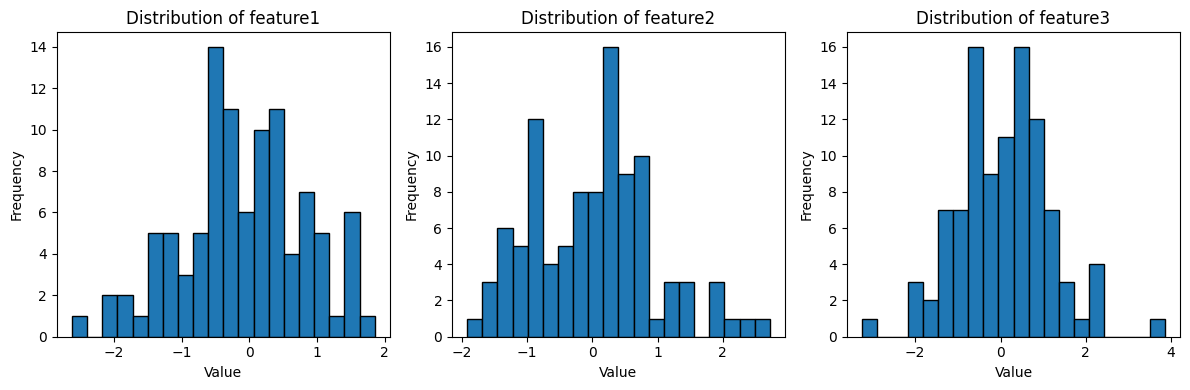

In [6]:
# Distribution plot
plt.figure(figsize=(12, 4))
for i, col in enumerate(['feature1', 'feature2', 'feature3'], 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

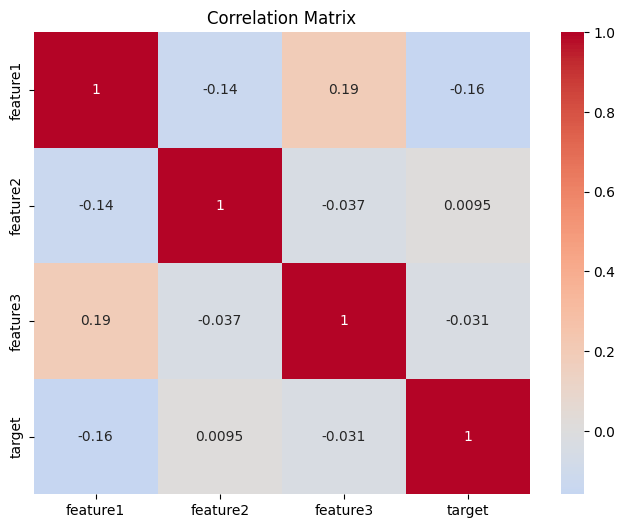

In [7]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Prepare Data for ML

In [8]:
X_train, X_test, y_train, y_test = analyzer.prepare_features('target')
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

INFO:ds.analyzer:Preparing features with target: target
INFO:ds.analyzer:Training set size: 80, Test set size: 20


Training set size: 80
Test set size: 20


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    expr,
    lower,
    regexp_replace,
    to_timestamp,
)
from pathlib import Path

from common.config import RAW_DIR, PROCESSED_DIR
from de.spark_jobs import traffy_basic_etl as etl


RAW_FILE = Path("../data/raw/bangkok_traffy.csv")
OUTPUT_DIR = Path("../data/preprocessed/traffy_cleaned_parquet")

In [10]:
def main():
    if not RAW_FILE.exists():
        raise FileNotFoundError(f"Raw file not found: {RAW_FILE}")

    spark = etl.build_spark()

    print(f"[ETL] Reading raw Traffy data from: {RAW_FILE}")
    df = (
        spark.read
        .option("header", True)
        .option("inferSchema", True)
        .csv(str(RAW_FILE))
    )

    print("[ETL] Basic profiling on raw data")
    etl.basic_profiling(df)

    print("[ETL] Cleaning data...")
    df_clean = etl.simple_clean(df)

    print("[ETL] Basic profiling on cleaned data")
    etl.basic_profiling(df_clean)

    # Save as Parquet (good for Spark)
    output_path = str(OUTPUT_DIR)
    print(f"[ETL] Writing cleaned data to: {output_path}")
    (
        df_clean
        .write
        .mode("overwrite")
        .parquet(output_path)
    )

    print("[ETL] Done.")
    spark.stop()

In [11]:
if __name__ == "__main__":
    main()

[ETL] Reading raw Traffy data from: ..\data\raw\bangkok_traffy.csv
[ETL] Basic profiling on raw data
=== Schema ===
root
 |-- ticket_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- organization: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- photo: string (nullable = true)
 |-- photo_after: string (nullable = true)
 |-- coords: string (nullable = true)
 |-- address: string (nullable = true)
 |-- subdistrict: string (nullable = true)
 |-- district: string (nullable = true)
 |-- province: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- state: string (nullable = true)
 |-- star: string (nullable = true)
 |-- count_reopen: string (nullable = true)
 |-- last_activity: string (nullable = true)

=== Row count ===
1718441
=== Sample rows ===
+--------------+-------------------------------------------------------------------------------------------------------------------+------------------------------+--------------------------

Py4JJavaError: An error occurred while calling o362.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:402)
	at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:325)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
	at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:192)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:622)
	at org.apache.spark.sql.classic.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.classic.DataFrameWriter.saveInternal(DataFrameWriter.scala:241)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:118)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:369)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
		at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
		at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
		at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
		at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
		at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:402)
		at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:325)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
		at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		... 1 more
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:601)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:622)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:645)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:742)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:80)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1954)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1912)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1885)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$install$1(ShutdownHookManager.scala:194)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.Option.fold(Option.scala:263)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:195)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:55)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:53)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:159)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala:63)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:250)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:99)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:379)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:961)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:204)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:227)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:96)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1132)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1141)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:521)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:492)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:569)
	... 27 more
